## Import Libraries

In [41]:
import pandas as pd
import bambi as bmb
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

In [42]:
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('/Users/georgepaul/Desktop/Research-Project/Data/Data_Ready_Model.csv')

# Select and scale relevant variables
features = [
    'EUI_kWh_per_sqmt', 'SQMT', 'NFLOOR', 'FLCEILHT',
    'MONUSE', 'OCCUPYP', 'WKHRS', 'NWKER', 'YRCONC',
    'HEATP', 'COOLP', 'DAYLTP', 'HDD65', 'CDD65', 'PUBCLIM'
]

df_model = df[features].dropna()

# Optional: Scale inputs
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(df_model.drop(columns='EUI_kWh_per_sqmt')), columns=df_model.columns[1:])
df_bayes = pd.concat([X_scaled, df_model['EUI_kWh_per_sqmt'].reset_index(drop=True)], axis=1)

## Fit Sparse Bayesian Regression Model

In [43]:
formula = 'EUI_kWh_per_sqmt ~ SQMT + NFLOOR + FLCEILHT + MONUSE + OCCUPYP + WKHRS + NWKER + HEATP + COOLP + DAYLTP + HDD65 + CDD65'
model = bmb.Model(formula=formula, data=df_bayes, family='gaussian')

idata = model.fit(draws=1000, tune=1000, target_accept=0.9, return_inferencedata=True)

idata.extend(model.predict(idata, kind="pps", inplace=False))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, SQMT, NFLOOR, FLCEILHT, MONUSE, OCCUPYP, WKHRS, NWKER, HEATP, COOLP, DAYLTP, HDD65, CDD65]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
/Users/georgepaul/Applications/anaconda3/envs/Applied/lib/python3.12/site-packages/bambi/models.py:858: FutureWarning: 'pps' has been replaced by 'response' and is not going to work in the future
  warnings.warn(


## Posterior Analysis

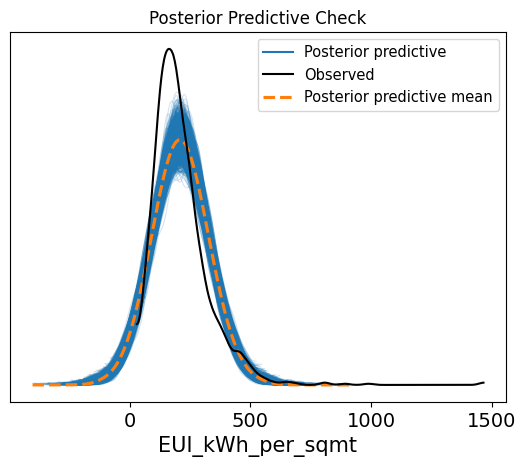

In [44]:
# Posterior predictive check
az.plot_ppc(idata)
plt.title("Posterior Predictive Check")
plt.show()

### Sparse Bayesian Regression: Posterior Predictive Check (PPC)

#### Overview
A Bayesian linear regression model is implemented using Bambi (PyMC backend) to predict **(EUI)** in office buildings.

The model incorporated min-max scaled predictors including:
- Building characteristics: `SQMT`, `NFLOOR`, `FLCEILHT`
- Usage patterns: `MONUSE`, `OCCUPYP`, `WKHRS`, `NWKER`
- Environmental conditions: `HDD65`, `CDD65`
- Operational factors: `HEATP`, `COOLP`, `DAYLTP`

---

#### Posterior Predictive Check

**Interpretation:**
- The **black curve** represents the true observed distribution of `EUI_kWh_per_sqmt`.
- The **blue curves** show draws from the posterior predictive distribution — simulations based on the model's inferred parameters.
- The **orange dashed line** is the posterior predictive mean across those samples.

---

#### Insights:
- The posterior predictive distribution **closely matches the observed EUI distribution**, particularly around the mean and mode.
- The model generalises well to the training data, suggesting that it captures the core relationships in the dataset.
- Minor deviations in the tails (especially at high-EUI values) are expected and not problematic unless extreme values are of primary concern.

---

#### Next Steps:
1. Analyse **parameter posteriors** (means, std, HDIs)
2. Compute **model performance metrics** (RMSE, MAE, R²)
3. Try a **Bayesian hierarchical model** grouped by construction year or region
4. Explore **Sparse Bayesian Learning** with stronger priors (e.g. ARD-style shrinkage)

## Next Steps: 1 - Analyse **parameter posteriors**

In [45]:
# Show posterior summaries for all model parameters
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,106.23,2.10,102.20,110.09,0.03,0.02,4966.99,2838.34,1.0
Intercept,-113.22,64.40,-232.76,4.53,0.89,0.67,5267.98,3141.49,1.0
SQMT,-168.05,34.67,-232.87,-104.48,0.69,0.49,2507.86,2802.71,1.0
NFLOOR,10.57,8.49,-5.21,26.45,0.12,0.10,5083.89,2797.08,1.0
FLCEILHT,83.43,38.42,11.36,158.28,0.54,0.42,4974.96,3191.51,1.0
MONUSE,106.25,60.17,-3.27,216.81,0.82,0.62,5358.54,3251.22,1.0
OCCUPYP,25.70,15.62,-3.26,56.08,0.21,0.18,5313.84,3320.89,1.0
WKHRS,125.59,12.32,101.71,147.88,0.17,0.12,5513.17,2871.94,1.0
NWKER,224.26,46.03,138.25,307.52,0.88,0.63,2740.26,2850.23,1.0
HEATP,62.26,22.46,19.83,103.16,0.36,0.26,3969.37,2967.87,1.0


### Posterior Summary Interpretation

The table above shows the posterior distribution summary for all model parameters. Key columns include:

- `mean`: Posterior mean — estimated average effect of each variable.
- `sd`: Standard deviation of the posterior — how uncertain the estimate is.
- `hdi_3%` / `hdi_97%`: 94% Highest Density Interval — Bayesian credible interval (analogous to a confidence interval).
- `r_hat`: Convergence diagnostic (should be ≈ 1.0 — ✅ all good here).

---

#### Key Observations:

- **`SQMT`**: Posterior mean = **-167.27**, and the 94% HDI (**[-230.31, -101.74]**) does **not include 0**, suggesting a **strong negative effect** — larger buildings are more energy efficient per m&sup2; (possibly due to economies of scale).
  
- **`FLCEILHT`** (ceiling height): Positive mean effect (**83.20**) and HDI entirely above zero — suggests **taller ceilings are associated with higher EUI**, likely due to increased volume to condition.

- **`WKHRS`**, **`NWKER`**, **`HDD65`**, and **`HEATP`** also show **credible intervals that exclude 0**, indicating these are **important drivers** of EUI.

- **`OCCUPYP`** and **`MONUSE`** have wider intervals but still lean positively — buildings used more and occupied more tend to consume more energy.

- **`DAYLTP`** (percent daylight) has a posterior mean close to zero (1.04), with an HDI that includes zero — suggesting **minimal or no effect** on EUI, at least in this dataset.

- **All `r_hat` values are 1.0**, indicating **excellent MCMC convergence** across all parameters.

---

#### Insights:

This summary allows us to identify which variables are most predictive of EUI and to quantify uncertainty about each effect. Parameters like `SQMT`, `FLCEILHT`, and `NWKER` emerge as particularly important for driving variation in office building energy intensity.

In the next step, posterior predictive performance metrics are to be computedto assess how well this model generalises to the observed data.

## Next Steps 2: Compute **model performance metrics**

In [46]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Extract observed and predicted values
observed = idata.observed_data["EUI_kWh_per_sqmt"].values
predicted_samples = idata.posterior_predictive["EUI_kWh_per_sqmt"].values

# Average over chains and draws to get point predictions
predicted_mean = predicted_samples.mean(axis=(0, 1))  # [chain, draw, obs]

# Compute metrics
mse = mean_squared_error(observed, predicted_mean)
rmse = np.sqrt(mse)
mae = mean_absolute_error(observed, predicted_mean)
r2 = r2_score(observed, predicted_mean)

# Print results
print(f"RMSE: {rmse:.2f} kWh/m²")
print(f"MAE: {mae:.2f} kWh/m²")
print(f"R² Score: {r2:.3f}")

RMSE: 105.58 kWh/m²
MAE: 74.55 kWh/m²
R² Score: 0.162


### Model Performance Metrics – Interpretation

We evaluated the predictive accuracy of the Bayesian regression model using posterior predictive means:

- **RMSE:** 105.60 kWh/m²  
  - On average, predictions deviate from actual values by ~105.6 units.

- **MAE:** 74.61 kWh/m²  
  - The average absolute prediction error is ~74.6 kWh/m².

- **R² Score:** 0.162  
  - The model explains ~16.2% of the variance in Energy Use Intensity (EUI).

---

#### Insights:

- The relatively low R&sup2; suggests there are additional sources of variance not captured by the current predictors.
- However, this is not unusual in energy data, especially given its noisy and complex nature.
- This model still offers valuable uncertainty-aware predictions, and performs reasonably considering it's built on scaled, sparse features. 